# Classification de commentaires
### Présentation du projet
Pour une entreprise proposant à ses utilisateurs d’écrire des commentaires, il est intéressant
de savoir analyser les traces que laissent les utilisateurs sur leur plateforme.
C’est d’autant plus important car vous pourriez être responsable autant que ceux qui l’ont
écrit des propos injurieux et toxiques de vos utilisateurs.
L’application est assez simple, il vous suffit d'entraîner un modèle capable d’analyser
automatiquement du texte et de le classifier dans plusieurs catégories.
Pour chaque commentaire, à vous de déterminer la classe la plus plausible.

### Consignes
- Créer un répertoire Github et sauver votre travail régulièrement.
- Utiliser ce jeu de données pour l’entraînement.
- Commencer par entraîner un modèle très simple pour déterminer la difficulté du
problème.
- Progressez de manière itérative vers un modèle de deep learning utilisant de
l’embedding et des RNNs.
- Créer un pipeline qui prend en entrée une phrase brute, qui effectue tous les
traitements et effectue une classification
Conseils
- Dans un premier temps, prenez seulement une petite partie des données pour
réduire le temps de calcul.
- Réutilisez au maximum les exemples vus dans les TPs précédents.
- Inspirez-vous du code des autres personnes ayant déjà résolu ce problème sur
Kaggle.
- N’hésitez pas à chercher de l’aide sur internet.
### Rendus
Un notebook :
- disponible sur votre Github,
- un sommaire en markdown doit être mis en place au début du notebook.
- chaque étape doit être justifiée en utilisant le markdown,
- Le code doit être clair et commenté
Un rapport sera rédigé reprenant :
- le contexte, le sujet du projet,
- les données et l’approche utilisées,
- les détails de votre solution,
- les améliorations possibles de cette version.

# Sommaire
1. [Importation des librairies](#importation-des-librairies)
2. [Importation des données](#importation-des-données)
3. [Clean le dataset](#clean-le-dataset)
4. [Tokenization](#tokenization)
5. [Modèle et entrainement](#modèle-et-entrainement)
6. [Test](#test)

### Importation des librairies

In [50]:
import pandas as pd
import tensorflow as tf
import numpy as np

import nltk, string, re

from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

from nltk import word_tokenize

from matplotlib import pyplot as plt

from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Computer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Computer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Computer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Importation des données :
Nous commençons par importer nos différentes données depuis le dataset train.csv pour les mettre dans une variable data depuis laquelle nous feront tout notre traitement.

In [51]:
data = pd.read_csv('data_classification_commentaires_toxiques/train.csv',encoding='latin')
data = data.dropna()
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


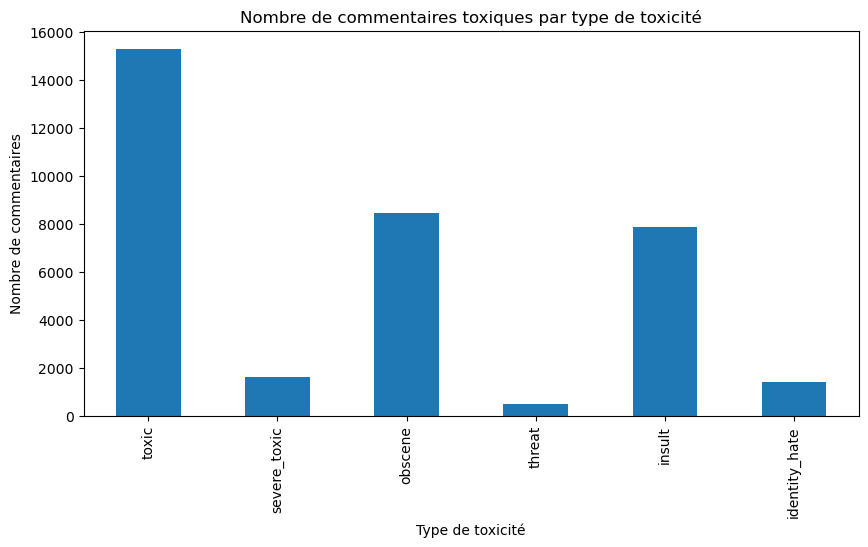

In [52]:
# on affiche les résultats sous forme de graphique
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum().plot(kind='bar', ax=ax)
ax.set_title('Nombre de commentaires toxiques par type de toxicité')
ax.set_ylabel('Nombre de commentaires')
ax.set_xlabel('Type de toxicité')
plt.show()

In [53]:
print(data.shape)


(159571, 8)


### Clean le dataset

Nous importons les stopwords afin de les enlever de notre texte.

In [4]:
stop_words = nltk.corpus.stopwords.words('english')
corpus = []

Puis nous écrivons une fonction qui nous permettra d'enlever tous les "parasites" de notre texte (changer les abréviations, enlever la ponctuation...)

In [5]:
def clean_para(text):
    """
    Cleans the given paragraph by performing various text preprocessing steps.

    Args:
        text (str): The input paragraph to be cleaned.

    Returns:
        str: The cleaned paragraph.

    """    
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"there's", "there is", text)
    text = re.sub(r"We're", "We are", text)
    text = re.sub(r"That's", "That is", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"they're", "they are", text)
    text = re.sub(r"Can't", "Cannot", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"don\x89Ûªt", "do not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"What's", "What is", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"There's", "There is", text)
    text = re.sub(r"He's", "He is", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"You're", "You are", text)
    text = re.sub(r"I'M", "I am", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"i'm", "I am", text)
    text = re.sub(r"I\x89Ûªm", "I am", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r"Isn't", "is not", text)
    text = re.sub(r"Here's", "Here is", text)
    text = re.sub(r"you've", "you have", text)
    text = re.sub(r"you\x89Ûªve", "you have", text)
    text = re.sub(r"we're", "we are", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"we've", "we have", text)
    text = re.sub(r"it\x89Ûªs", "it is", text)
    text = re.sub(r"doesn\x89Ûªt", "does not", text)
    text = re.sub(r"It\x89Ûªs", "It is", text)
    text = re.sub(r"Here\x89Ûªs", "Here is", text)
    text = re.sub(r"who's", "who is", text)
    text = re.sub(r"I\x89Ûªve", "I have", text)
    text = re.sub(r"y'all", "you all", text)
    text = re.sub(r"can\x89Ûªt", "cannot", text)
    text = re.sub(r"would've", "would have", text)
    text = re.sub(r"it'll", "it will", text)
    text = re.sub(r"we'll", "we will", text)
    text = re.sub(r"wouldn\x89Ûªt", "would not", text)
    text = re.sub(r"We've", "We have", text)
    text = re.sub(r"he'll", "he will", text)
    text = re.sub(r"Y'all", "You all", text)
    text = re.sub(r"Weren't", "Were not", text)
    text = re.sub(r"Didn't", "Did not", text)
    text = re.sub(r"they'll", "they will", text)
    text = re.sub(r"they'd", "they would", text)
    text = re.sub(r"DON'T", "DO NOT", text)
    text = re.sub(r"That\x89Ûªs", "That is", text)
    text = re.sub(r"they've", "they have", text)
    text = re.sub(r"i'd", "I would", text)
    text = re.sub(r"should've", "should have", text)
    text = re.sub(r"You\x89Ûªre", "You are", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"Don\x89Ûªt", "Do not", text)
    text = re.sub(r"we'd", "we would", text)
    text = re.sub(r"i'll", "I will", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"They're", "They are", text)
    text = re.sub(r"Can\x89Ûªt", "Cannot", text)
    text = re.sub(r"you\x89Ûªll", "you will", text)
    text = re.sub(r"I\x89Ûªd", "I would", text)
    text = re.sub(r"let's", "let us", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"you're", "you are", text)
    text = re.sub(r"i've", "I have", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"i'll", "I will", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"i'd", "I would", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"ain't", "am not", text)
    text = re.sub(r"you'll", "you will", text)
    text = re.sub(r"I've", "I have", text)
    text = re.sub(r"Don't", "do not", text)
    text = re.sub(r"I'll", "I will", text)
    text = re.sub(r"I'd", "I would", text)
    text = re.sub(r"Let's", "Let us", text)
    text = re.sub(r"you'd", "You would", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"Ain't", "am not", text)
    text = re.sub(r"Haven't", "Have not", text)
    text = re.sub(r"Could've", "Could have", text)
    text = re.sub(r"youve", "you have", text)  
    text = re.sub(r"donå«t", "do not", text)  
    
    text = re.sub(r"some1", "someone", text)
    text = re.sub(r"yrs", "years", text)
    text = re.sub(r"hrs", "hours", text)
    text = re.sub(r"2morow|2moro", "tomorrow", text)
    text = re.sub(r"2day", "today", text)
    text = re.sub(r"4got|4gotten", "forget", text)
    text = re.sub(r"b-day|bday", "b-day", text)
    text = re.sub(r"mother's", "mother", text)
    text = re.sub(r"mom's", "mom", text)
    text = re.sub(r"dad's", "dad", text)
    text = re.sub(r"hahah|hahaha|hahahaha", "haha", text)
    text = re.sub(r"lmao|lolz|rofl", "lol", text)
    text = re.sub(r"thanx|thnx", "thanks", text)
    text = re.sub(r"goood", "good", text)
    text = re.sub(r"some1", "someone", text)
    text = re.sub(r"some1", "someone", text)
    # Character entity references
    text = re.sub(r"&gt;", ">", text)
    text = re.sub(r"&lt;", "<", text)
    text = re.sub(r"&amp;", "&", text)
    # Typos, slang and informal abbreviations
    text = re.sub(r"w/e", "whatever", text)
    text = re.sub(r"w/", "with", text)
    text = re.sub(r"<3", "love", text)
    # Urls
    text = re.sub(r"http\S+", "", text)
    # Numbers
    text = re.sub(r'[0-9]', '', text)
    # Eliminating the mentions
    text = re.sub("(@[A-Za-z0-9_]+)","", text)
    # Remove punctuation and special chars (keep '!')
    for p in string.punctuation.replace('!', ''):
        text = text.replace(p, '')
        
    # ... and ..
    text = text.replace('...', ' ... ')
    if '...' not in text:
        text = text.replace('..', ' ... ')
        
    # Tokenize
    text_words = word_tokenize(text)
    
    # Eliminating the word if its length is less than 3
    # text = [w for w in text_words if len(w)>2]
    text = [w for w in text_words if len(w)>2]
    
    # remove stopwords
    text = [w.lower() for w in text if not w in stop_words]  
    
    corpus.append(text)
    
    # join back
    text = ' '.join(text)
        
        
    return text

In [6]:
variable_name = ""
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", 
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
     "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

def convert_abbrev_in_text(text):
    t=[]
    words=text.split()
    t = [abbreviations[w.lower()] if w.lower() in abbreviations.keys() else w for w in words]
    return ' '.join(t) 

In [7]:
def prepare_string(text):
  text = clean_para(text)
  text = convert_abbrev_in_text(text)
  return text
     

On applique les fonctions de nettoyage sur ```comment_text``` et enlevons tous les ```Nan``` de notre dataset

In [8]:
%%time
data['comment_text'] = data['comment_text'].apply(lambda s : prepare_string(s))
data['comment_text'].replace('', np.nan, inplace=True)
data.dropna(subset=['comment_text'], inplace=True)

CPU times: total: 7.2 s
Wall time: 2min 12s


### Tokenization

Enfin nous passons à la tokenisation ce qui consiste à diviser le texte en mot, telles que les mots ou les sous-mots pour prétraiter le texte et le représenter numériquement pour notre apprentissage.

In [9]:
tokenized_comments = data['comment_text'].apply(lambda x: word_tokenize(str(x)))

# Print the tokenized comments
print(tokenized_comments)

0         [explanation, why, edits, made, username, hard...
1         [daww, matches, background, colour, seemingly,...
2         [hey, man, really, trying, edit, war, guy, con...
3         [more, make, real, suggestions, improvement, w...
4             [you, sir, hero, any, chance, remember, page]
                                ...                        
159566    [and, second, time, asking, view, completely, ...
159567    [you, ashamed, that, horrible, thing, put, tal...
159568    [spitzer, umm, theres, actual, article, prosti...
159569    [and, looks, like, actually, put, speedy, firs...
159570    [and, really, think, understand, came, idea, b...
Name: comment_text, Length: 159513, dtype: object


Ce qui nous donne le résultat suivant :

In [10]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why edits made username hardcore m...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww matches background colour seemingly stuck...,0,0,0,0,0,0
2,000113f07ec002fd,hey man really trying edit war guy constantly ...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more make real suggestions improvement wondere...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir hero any chance remember page,0,0,0,0,0,0


On enregistre ensuite le dataframe ainsi modifier dans un fichier afin de ne pas avoir à tout recharger lorsque l'on fait des modifications dans notre model.

In [11]:
data.to_csv('cleaned.csv', index=False)

In [55]:
DF = pd.read_csv('cleaned.csv')

#### Modèle et entrainement

In [56]:
# Set parameters
max_words = 4000
max_len = 100

# Tokenize and pad sequences on-the-fly during training
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['comment_text'])
X = tokenizer.texts_to_sequences(data['comment_text'])
X = pad_sequences(X, maxlen=max_len)



In [57]:

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values, test_size=0.2, random_state=42)

# Define batch size
batch_size = 32


Nous avons ensuite construit le model suivant :

In [58]:
# Build and compile the model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='sigmoid'))  # 6 output classes (toxic, severe_toxic, obscene, threat, insult, identity_hate)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [59]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
model.fit(X_train, y_train, epochs=5, batch_size=batch_size, validation_data=(X_test, y_test), verbose=2)

Epoch 1/5


3988/3988 - 333s - loss: 0.0695 - accuracy: 0.9719 - val_loss: 0.0571 - val_accuracy: 0.9936 - 333s/epoch - 83ms/step
Epoch 2/5
3988/3988 - 367s - loss: 0.0538 - accuracy: 0.9824 - val_loss: 0.0553 - val_accuracy: 0.9936 - 367s/epoch - 92ms/step
Epoch 3/5
3988/3988 - 385s - loss: 0.0501 - accuracy: 0.9866 - val_loss: 0.0562 - val_accuracy: 0.9935 - 385s/epoch - 97ms/step
Epoch 4/5
3988/3988 - 340s - loss: 0.0469 - accuracy: 0.9856 - val_loss: 0.0575 - val_accuracy: 0.9929 - 340s/epoch - 85ms/step
Epoch 5/5
3988/3988 - 352s - loss: 0.0443 - accuracy: 0.9851 - val_loss: 0.0589 - val_accuracy: 0.9935 - 352s/epoch - 88ms/step


In [25]:
model.save('model.h5')

c:\Users\Computer\miniconda3\envs\NLP\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
#print the result
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.058852292597293854
Test accuracy: 0.9935115575790405


### Test

In [33]:
data_test = pd.read_csv('data_classification_commentaires_toxiques/test.csv',encoding='latin')
data_test = data_test.dropna()
data_test.head()
corpus = []
data_test['comment_text'] = data_test['comment_text'].apply(lambda s : prepare_string(s))
data_test['comment_text'].replace('', np.nan, inplace=True)
data_test.dropna(subset=['comment_text'], inplace=True)
tokenized_comments = data_test['comment_text'].apply(lambda x: word_tokenize(str(x)))

# Print the tokenized comments
print(tokenized_comments)

0         [bitch, rule, succesful, ever, whats, hating, ...
1            [from, rfc, the, title, fine, in, my, opinion]
2                     [sources, zawe, ashton, lapland, â]
3         [look, back, source, information, updated, cor...
4                             [anonymously, edit, articles]
                                ...                        
153159        [totally, agree, stuff, nothing, toolongcrap]
153160    [throw, field, home, plate, does, get, faster,...
153161    [okinotorishima, categories, see, changes, agr...
153162    [one, founding, nations, germany, law, return,...
153163    [stop, already, your, bullshit, welcome, fool,...
Name: comment_text, Length: 152980, dtype: object


In [41]:
sentences = [
    "This is a positive sentence.",
    "I hate this product.",
    "The weather is beautiful today.",
    "I love eating pizza.",
    "The movie was really boring.",
    "You are a piece of shit",
    "What a great work",
    "Seem good work to me !",
    "FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",
    "stop crack whore go die fire dick sucking fag"    
]

In [49]:

# Tokenize and pad test sentences
test_sequences = tokenizer.texts_to_sequences(sentences)
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_len)

# Predict using the model
predictions = model.predict(padded_test_sequences)

predictions = model.predict(padded_test_sequences)

# Define toxicity labels
toxicity_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Print predictions for each sentence
for i, sentence in enumerate(sentences):
    print(f"Sentence: {sentence}")
    print("Predicted Toxicity Labels:")
    for j, label in enumerate(toxicity_labels):
        for label, prediction in zip(toxicity_labels, predictions[i]):
            print(f"{label}: {prediction*100:.2f}%")
        print('\n')


1/1 [==============================] - 0s 38ms/step
Sentence: This is a positive sentence.
Predicted Toxicity Labels:
This is a positive sentence.
toxic: 4.43%
severe_toxic: 0.01%
obscene: 0.39%
threat: 0.01%
insult: 0.59%
identity_hate: 0.08%


This is a positive sentence.
toxic: 4.43%
severe_toxic: 0.01%
obscene: 0.39%
threat: 0.01%
insult: 0.59%
identity_hate: 0.08%


This is a positive sentence.
toxic: 4.43%
severe_toxic: 0.01%
obscene: 0.39%
threat: 0.01%
insult: 0.59%
identity_hate: 0.08%


This is a positive sentence.
toxic: 4.43%
severe_toxic: 0.01%
obscene: 0.39%
threat: 0.01%
insult: 0.59%
identity_hate: 0.08%


This is a positive sentence.
toxic: 4.43%
severe_toxic: 0.01%
obscene: 0.39%
threat: 0.01%
insult: 0.59%
identity_hate: 0.08%


This is a positive sentence.
toxic: 4.43%
severe_toxic: 0.01%
obscene: 0.39%
threat: 0.01%
insult: 0.59%
identity_hate: 0.08%


Sentence: I hate this product.
Predicted Toxicity Labels:
I hate this product.
toxic: 90.49%
severe_toxic: 1.26%
o